In [114]:
using JuMP, Gurobi

    dims = 3
    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(dims,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 1   4   6   1
           1   3   0   1 
           1   2   2   1 ];

In [115]:
mass = 10
g = [0 0 -9.8]';

In [116]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    
    @variable(m, x[1:dims,1:T[k]])  # resulting position
    @variable(m, v[1:dims,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])     # thruster input x-y
    @variable(m, uz[1:4, 1:T[k]])   # thruster input z axis

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== zeros(dims,1)')

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[1:2,t+1] .== v[1:2,t] + u[:,t])
        @constraint(m, v[3,t+1] == v[3,t] + sum(uz[i,t] for i in 1:4) + g[3])
    end

    # hit all the waypoints
    for i in [1 k]
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    @objective(m, Min, sum(uz.^2) + sum(u.^2) + λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  ) )
    solve(m)

:Optimal

In [117]:
xopt = getvalue(x)

3×60 Array{Float64,2}:
 1.0  1.0  1.02433  1.0718   1.14121  1.23136  …   2.13907    1.57171   1.0
 1.0  1.0  1.02919  1.08448  1.16279  1.26102      0.720522   0.859019  1.0
 1.0  1.0  1.22761  1.64369  2.20912  2.88475     43.8197    26.7508    1.0

In [118]:
uopt = getvalue(u)

2×60 Array{Float64,2}:
 0.0243338  0.0231355  0.0219373  0.0207391  …  -0.0043463   -0.0  -0.0
 0.0291896  0.0261024  0.0230153  0.0199281      0.00248394  -0.0  -0.0

In [119]:
uoptZ = getvalue(uz)

4×60 Array{Float64,2}:
 2.5069  2.49712  2.48734  2.47755  …  0.559076  0.279538  -0.0  -0.0
 2.5069  2.49712  2.48734  2.47755     0.559076  0.279538  -0.0  -0.0
 2.5069  2.49712  2.48734  2.47755     0.559076  0.279538  -0.0  -0.0
 2.5069  2.49712  2.48734  2.47755     0.559076  0.279538  -0.0  -0.0

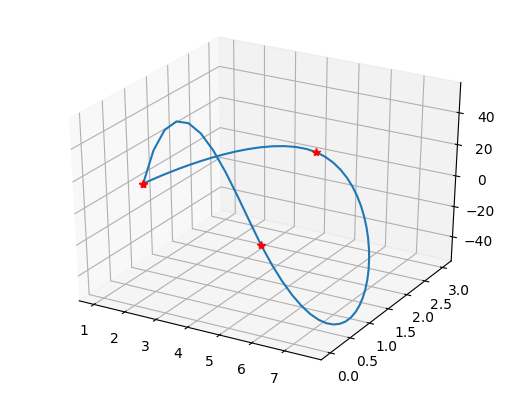

In [120]:
using PyPlot
plot3D(xopt[1,:],xopt[2,:],xopt[3,:])
plot3D(xw[1,:],xw[2,:],xw[3,:],"r*");